In [12]:
import pandas as pd

with open('../data/DatasetCleaned.csv', 'r') as f:
    data = pd.read_csv(f)

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score

import pandas as pd
from tqdm import tqdm
import numpy as np

def RegrLasso(Y_data:pd.Series, X_data:pd.DataFrame, alpha, #Function imported from another project of mine, see https://github.com/Interorm/IMF-Bias---Hausarbeit
              display:bool=True, iter:int=100000):
    
    dependent_var = Y_data.name

    Y = Y_data.copy().values
    X = X_data.copy().values.reshape(-1, X_data.shape[1])
    feature_names = X_data.columns
    
    if display:
        coefs_all = [] 
        mse = []
        for a in tqdm(alpha): 
            lasso = Lasso(alpha=a,  max_iter=1000000, tol=1e-4)
            lasso.fit(X, Y) 
            coefs_all.append(lasso.coef_) 
            mse_this = ( -cross_val_score(lasso, X, Y, scoring="neg_mean_squared_error", cv=KFold()) )
            mse_this = np.mean(mse_this)
            mse.append(mse_this)
        coefs_all = np.array(coefs_all)
    

    lasso_cv = LassoCV(alphas=alpha, cv=KFold(), max_iter=100000)
    lasso_cv.fit(X, Y)

    best_alpha = lasso_cv.alpha_
    print("Best alpha:", best_alpha)

    
    print(f"R²: {lasso_cv.score(X,Y)}")

    coefs = []
    for i, featuer in enumerate(feature_names):
        coef = lasso_cv.coef_[i]
        if coef == 0: continue
        coefs.append({"Regressor": featuer, "Coefficient": coef})
    coefs = sorted(coefs, key = lambda x: x["Coefficient"], reverse=True)
    for coef in coefs: 
        c = round(coef["Coefficient"], 4)
        r = coef["Regressor"]
        if any(True for fixed in ["Region", "Country"] if fixed in r): continue
        print(f"{r}: {c}")

    if display: 
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))
        
        # Top Left axis: MSE
        ax1.plot(alpha, mse, color="red", linewidth=2, label="CV MSE")
        ax1.set_xlabel("Lambda")
        ax1.set_xscale("log")
        ax1.set_ylabel("Mean Squared Error")
        ax1.set_title('Mean Squared Error')
        ax1.axvline(x = best_alpha, color = 'black', linestyle = '--')
        #ax1.tick_params(axis="y", labelcolor="red")

        # Top Right axis: Coefficients
        colors = sns.color_palette("Paired", len(feature_names))
        for i, name in enumerate(feature_names):
            if any(True for fixed in ["Region", "Country"] if fixed in name): continue
            ax2.plot(alpha, coefs_all[:, i], label=name, color=colors[i])
        ax2.set_xlabel("Lambda")
        ax2.set_xscale("log")
        ax2.set_ylabel("Coefficient values")
        ax2.set_title("Lasso Coefficients vs Lambda")
        ax2.axvline(x = best_alpha, color = 'black', linestyle = '--')
        ax2.grid(True)

        # Bottom Left: Predcition vs. Truth
        Y_predicted = pd.DataFrame({'Predicted':lasso_cv.predict(X), 'True':Y})
        Y_predicted = Y_predicted.sort_values(by='True')
        ax3.plot( Y_predicted['True'], Y_predicted['Predicted'], color='lightblue', label='Predicted Values' )
        ax3.plot( Y_predicted['True'], Y_predicted['True'], color = 'red' )
        ax3.set_xlabel(f'Actual {dependent_var}')
        ax3.set_ylabel(f'Predicted {dependent_var}')
        ax3.set_title('Prediction vs. Reality for Best Model')
        ax3.grid(False)

        # Bottom Right: Number of relevant Coef
        ax4.plot(alpha, np.count_nonzero(coefs_all, axis=1), color='red', label = 'Non-Zero Coefficients')
        ax4.set_xlabel("Lambda")
        ax4.set_xscale("log")
        ax4.set_ylabel("# Non-Zero Coefficients")
        ax4.set_title("Non-Zero Coefficients")
        ax4.axvline(x = best_alpha, color = 'black', linestyle = '--')
        ax4.grid(True)


        plt.tight_layout()
        plt.show()

    return lasso_cv


In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer, RobustScaler

Y = np.log(data['SalePrice'])
Y.name = 'SalePrice_log'


X = data.copy()

X_prep = pd.DataFrame(index=X.index)
X_prep['Intercept'] = 1

X_types = X.dtypes.to_dict()
scaler = PowerTransformer(method='yeo-johnson')

for col, t in X_types.items():
    if col in ['SalePrice','Unnamed: 0']: continue

    if set(X[col].unique()).issubset({0,0.5,1}): #Handles dummy columns computed in Preperation
        X_prep[col] = X[col].copy()
        continue

    if t == 'object': 
        new_col = pd.get_dummies(X[col], prefix=col, drop_first=True, dtype=int)
        for dummy_col in new_col.columns:
            X_prep[dummy_col] = new_col[dummy_col]
        continue

    if t in ['int', 'float']:
        nonapplicable = X[col] == -1

        new_col = X[col].copy()
        applic_values = new_col.loc[~nonapplicable].values.reshape(-1, 1)
        new_col.loc[~nonapplicable] = scaler.fit_transform(applic_values).flatten()
        new_col.loc[nonapplicable] = 0

        X_prep[col] = new_col
        
        continue

    print(f'Type \"{t}\" not in standard types!')

X = X_prep

C:\Users\karli\AppData\Local\Temp\ipykernel_57224\2391549182.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.14545181  0.09841449  0.40342175 ... -1.70419946  3.88329402
 -0.37218074]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_col.loc[~nonapplicable] = scaler.fit_transform(applic_values).flatten()
C:\Users\karli\AppData\Local\Temp\ipykernel_57224\2391549182.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.677626   -0.03607174  0.677626   ... -0.03607174  2.67851644
 -0.78029271]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_col.loc[~nonapplicable] = scaler.fit_transform(applic_values).flatten()
C:\Users\karli\AppData\Local\Temp\ipykernel_57224\2391549182.py:35: FutureWarning: Setting an item of incompatible d

100%|██████████| 500/500 [00:55<00:00,  9.07it/s]


Best alpha: 0.0006202762753208046
R²: 0.9149398530570815
Neighborhood_StoneBr: 0.1225
Has_Basement: 0.1223
Neighborhood_Crawfor: 0.1008
OverallQual: 0.0918
Neighborhood_Somerst: 0.0881
Neighborhood_NoRidge: 0.0818
MSSubClass_1-1/2 STORY FINISHED ALL AGES: 0.0761
1stFlrSF: 0.0717
Has_Garage: 0.0706
Neighborhood_NridgHt: 0.0665
HouseStyle_2Story: 0.0609
SaleCondition_Normal: 0.0568
Condition1_Norm: 0.0514
SaleType_New: 0.0502
OverallCond: 0.0484
Exterior1st_BrkFace: 0.0471
MSSubClass_2-1/2 STORY ALL AGES: 0.0456
2ndFlrSF: 0.0426
Neighborhood_BrkSide: 0.0424
LotArea: 0.0422
Has_Fireplace: 0.0422
CentralAir: 0.0385
Neighborhood_ClearCr: 0.0379
Bathrooms: 0.0373
MSZoning_RL: 0.0367
TotRmsAbvGrd: 0.03
GarageCars: 0.0254
Sold_07-2007: 0.0243
BsmtFinSF1: 0.0213
TotalBsmtSF: 0.021
Sold_07-2009: 0.021
GarageFinish: 0.0205
Foundation_PConc: 0.0198
Sold_12-2007: 0.0195
LandSlope_Mod: 0.0155
RoofMatl_WdShngl: 0.0151
BsmtBathrooms: 0.015
BsmtQual: 0.0135
HeatingQC: 0.0133
FireplaceQu: 0.0118
WoodDec

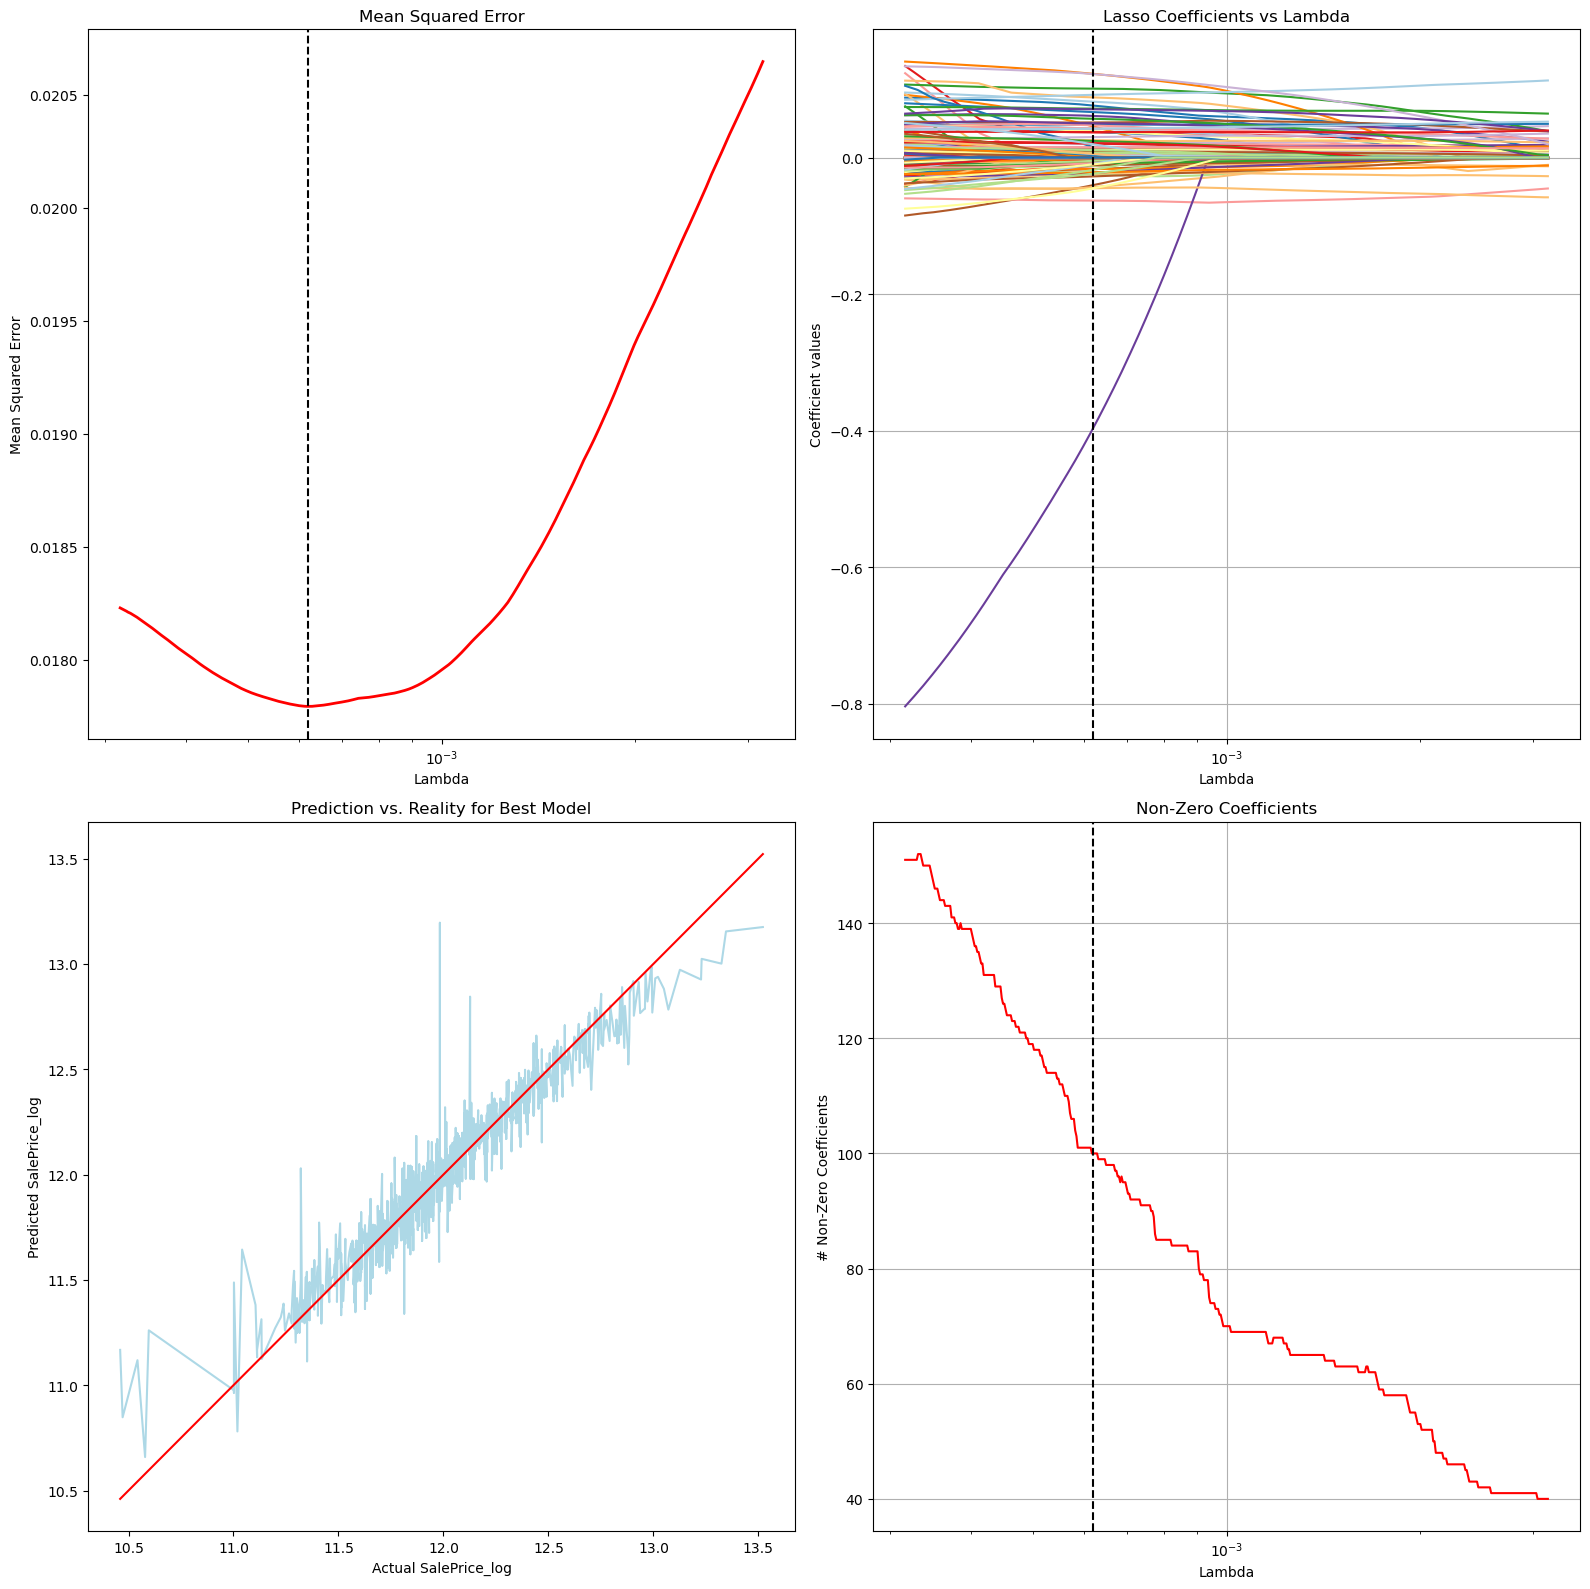

In [15]:
lasso_model = RegrLasso(Y, X, alpha=np.logspace(-3.5,-2.5,500))

In [16]:
import pickle

SAVE = True

if SAVE: 
    with open('../models/Lasso.sav', 'wb') as f: pickle.dump(lasso_model, f)